https://sejaumdatascientist.com/como-criar-um-programa-de-fidelidade-para-empresa/

# Cicle

### Cicle 01
- Foundout 3 potencial clusters using the data as it is.

Next cicles:
- Need to make some feature engineering
- Deal with NA values
- Run others clustering algorithms

### Cicle 02
- Data is still messy. Got a similar cluster as cicle 01.
- Dealt with NA values
- Have runned other clustering algorithms to find a optimal cluster

Next cicles:
- Need to make some feature engineering

### Cicle 03
- Created 3 clusters and the average gross revenue adjusted seems to be more acurate then the previous circle.
- The data have been separeted in "good return", "qtd adjustment", "free purchase" and "normal purchase". It was possible to identify strange information in the data and it was treated creating new features.

Next cicles:
- Futher investigation on description / stock_code to "break" the hude cluster
- Data of purchase need to be analyzed to create new features
- The last cicles indicated some anomaly with customer with 0 or negative total purchase adjusted. Since we are not interested in this behaviour, we are going to remove it.

### Cicle 04
- This cicles we explored the "describe" columns with several features counting the frequency of each word.
- It was possible to create a cluster with most of people spending in avg $157.460,93 with 6 customers. But it didn´t capture the most speding customers, because there are a few in other clusters.

Next cicles:
- Data of purchase need to be analyzed to create new features
- Make a analyzis on the space using PCA or UMAP.

### Cicle 05
- "Date" feature has been developed creating new features.

Next cicles:
- Make a analyzis on the space using PCA or UMAP.

### Cicle 06
- Before making analyzis with PCA or UMAP, it was given another analyzies with "description" feature, since the counting frequency didn´t clustered similar words.
- It was taken 4 approuches, where it was choosen the one TDIF VECTORIZER + KMEANS CLUSTERING

Next cicles:
- Make a analyzis on the space using PCA or UMAP.

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - **Alto Ticket Médio**
                + média dos preços pagos
            - **Alto LTV (life time value)**
                + quanto foi gasto na empresa
            - **Baixa Recência ou Alta Frequência**
                + tempo entre as compras - contado em dias
            - **Alto Basket Size**
                + quantidade média de produtos comprados
            - **Baixa probabilidade de Churn**
                + encerramento de contrato ou baixa da relação com a empresa
            - **Previsão alta de LTV**
            - **Alta propensão de compra**

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País / Localização
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Atributos da clusterização / Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Análise de Cohort (marcação do grupo e seu comportamento ao longo do tempo)
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ? (1 mês, 3 meses...?)
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import sklearn
import yellowbrick
import umap.umap_ as umap
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

import nltk
from nltk.tokenize import RegexpTokenizer

from IPython.core.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx
from sklearn import ensemble      as en
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

pd.options.display.float_format = '{:.2f}'.format

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding='unicode_escape')

# drop extra columns
df_raw.drop('Unnamed: 8', axis=1, inplace=True)

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()
df1.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55    17850.00  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39    17850.00  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75    17850.00  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39    17850.00  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39    17850.00  United Kingdom

## 1.1. Rename columuns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# storing columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [6]:
df1.shape

(541909, 8)

## 1.3. Data types

In [6]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

### 1.5.1 Description

In [7]:
# replace with existing description by stock_code
df1aux = df1[~df1['description'].isna()]
aux3 = df1aux[['stock_code', 'description']].drop_duplicates('stock_code')
df1 = df1.drop(columns='description')
df1_ = pd.merge(df1, aux3, how='left', on='stock_code')
df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
description        112
dtype: int64

In [8]:
# the remaing 112 records have 0 values for unit_price. it is going to bel erased
df1_ = df1_.dropna(subset=['description'])

df1 = df1_.copy()

df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     134968
country              0
description          0
dtype: int64

### 1.5.2 Customer ID 

In [9]:
df1['customer_id'].isna().sum()/df1.shape[0]

0.24911175218762746

In [9]:
aux_na = df1[df1['customer_id'].isna()].copy()
aux_na['gross_revenue_na'] = aux_na['unit_price']*aux_na['quantity']
print("Total Gross Revenue NA $ %.2f" % aux_na['gross_revenue_na'].sum())
aux = df1[~df1['customer_id'].isna()].copy()
aux['gross_revenue_na'] = aux['unit_price']*aux['quantity']
print("Total Gross Revenue $ %.2f" % aux['gross_revenue_na'].sum())
print("Percentage of Total (not NA): %.2f" % (aux_na['gross_revenue_na'].sum()/aux['gross_revenue_na'].sum()*100), '%')

Total Gross Revenue NA $ 1447682.12
Total Gross Revenue $ 8300065.81
Percentage of Total (not NA): 17.44 %


In [10]:
df1_ = df1.copy()
df1_.shape

(541797, 8)

In [11]:
# create reference - artificial customer to not drop the records
df_backup = pd.DataFrame( aux_na['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 30000, 30000+len( df_backup ), 1) 

# merge original with reference dataframe
df1_ = pd.merge( df1_, df_backup, on='invoice_no', how='left' )

# coalesce (command from SQL)
df1_['customer_id'] = df1_['customer_id_x'].combine_first( df1_['customer_id_y'] )

# drop extra columns
df1_ = df1_.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [12]:
df1 = df1_.copy()
df1_.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
country         0
description     0
customer_id     0
dtype: int64

## 1.6. Change dtypes

In [13]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype('int32')
df1['quantity'] = df1['quantity'].astype('int32')
df1.dtypes

invoice_no              object
stock_code              object
quantity                 int32
invoice_date    datetime64[ns]
unit_price             float64
country                 object
description             object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [17]:
describe_num(num_attributes)

attibutes     count          mean          std       25%       50%       75%       min      max      range        skew       kurtosis  unique
0     quantity  541797.0      9.555919   218.103428      1.00      3.00     10.00 -80995.00  80995.0  161990.00   -0.264100  119744.998246   722.0
1   unit_price  541797.0      4.612067    96.769831      1.25      2.08      4.13 -11062.06  38970.0   50032.06  186.487799   58993.571524  1630.0
2  customer_id  541797.0  19408.827880  7330.497961  14367.00  16245.00  18283.00  12346.00  33597.0   21251.00    1.041805      -0.681252  7970.0

**quantity** - There is some strange values in the max and min values. Need further investigation

**unit_price** - There is some product with price equals 0 and a max values of 38.970. Need further investigation

### 1.7.2. Categorical Attibutes

In [115]:
cat_attributes.apply( lambda x: x.unique().shape[0])

invoice_no     25788
stock_code      3958
country           38
description     3817
dtype: int64

# <font color='red'> 2.0. Feature Engineering </font>

In [14]:
df2 = df1.copy()
df2.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id'],
      dtype='object')

In [15]:
df2.head()

invoice_no stock_code  quantity invoice_date  unit_price         country                          description  customer_id
0     536365     85123A         6   2016-11-29        2.55  United Kingdom   WHITE HANGING HEART T-LIGHT HOLDER        17850
1     536365      71053         6   2016-11-29        3.39  United Kingdom                  WHITE METAL LANTERN        17850
2     536365     84406B         8   2016-11-29        2.75  United Kingdom       CREAM CUPID HEARTS COAT HANGER        17850
3     536365     84029G         6   2016-11-29        3.39  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE        17850
4     536365     84029E         6   2016-11-29        3.39  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.        17850

### 2.1. GROSS REVENUE

In [15]:
# gross revenue
df2['gross_revenue'] = df2['unit_price'] * df2['quantity']

### 2.2. GOOD RETURN

In [16]:
df2['good_return'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] > 0) else 0, axis=1)

### 2.3. QNTD ADJUSTMENT

In [17]:
df2['qtd_adjustment'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.4. FREE PURCHASE

In [18]:
df2['free_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.5. NORMAL PURCHASE

In [19]:
df2['normal_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] > 0) else 0, axis=1)

In [21]:
df2.sample(40)

invoice_no stock_code  quantity invoice_date  unit_price         country                          description  customer_id  gross_revenue  good_return  qtd_adjustment  free_purchase  normal_purchase
157527     550208      48138         1   2017-04-13       14.13  United Kingdom                   DOORMAT UNION FLAG        31249          14.13            0               0              0                1
243599     558475      85054         1   2017-06-27        5.79  United Kingdom              FRENCH ENAMEL POT W LID        31982           5.79            0               0              0                1
422090     573070      23264         2   2017-10-25        1.25  United Kingdom   SET OF 3 WOODEN SLEIGH DECORATIONS        13263           2.50            0               0              0                1
113915     546004      21535         1   2017-03-06        2.55  United Kingdom         RED RETROSPOT SMALL MILK JUG        30756           2.55            0               0              0                1
407140     571850      23393         4   2017-10-17        3.75  United Kingdom       HOME SWEET HOME CUSHION COVER         14698          15.00            0               0              0                1
106204     545317      22721         1   2017-02-27       10.79  United Kingdom        SET OF 3 CAKE TINS SKETCHBOOK        30708          10.79            0               0              0                1
76926      542664      84988         3   2017-01-29        2.92  United Kingdom   SET OF 72 PINK HEART PAPER DOILIES        30513           8.76            0               0              0                1
96725      544586      22723         3   2017-02-19        3.95  United Kingdom        SET OF 6 HERB TINS SKETCHBOOK        17338          11.85            0               0              0                1
198021     554013      22139         6   2017-05-18        4.95  United Kingdom     RETROSPOT TEA SET CERAMIC 11 PC         13308          29.70            0               0              0                1
540631     581492      22123         1   2017-12-07        4.13  United Kingdom                 PING MICROWAVE APRON        33595           4.13            0               0              0                1
501016     578819      22386       100   2017-11-23        1.79  United Kingdom              JUMBO BAG PINK POLKADOT        15311         179.00            0               0              0                1
507756     579187      23613         3   2017-11-26        2.49  United Kingdom     SET 10 XMAS CARDS & BADGES 17070        33459           7.47            0               0              0                1
269189     560444     85099F         3   2017-07-16        2.08  United Kingdom                 JUMBO BAG STRAWBERRY        13764           6.24            0               0              0                1
301381     563300     47566B         6   2017-08-13        4.95  United Kingdom               TEA TIME PARTY BUNTING        16774          29.70            0               0              0                1
159038     550325      22115         6   2017-04-15        2.95  United Kingdom                METAL SIGN EMPIRE TEA        15745          17.70            0               0              0                1
436384     574154      22720         3   2017-11-01        4.95  United Kingdom    SET OF 3 CAKE TINS PANTRY DESIGN         13709          14.85            0               0              0                1
92685      544204      22212         2   2017-02-15        4.13  United Kingdom           FOUR HOOK  WHITE LOVEBIRDS        30632           8.26            0               0              0                1
322234     565232      21625         2   2017-08-31       14.13  United Kingdom             VINTAGE UNION JACK APRON        32509          28.26            0               0              0                1
434987     574074      21888         1   2017-10-31        7.46  United Kingdom              

# <font color='red'> 3.0. Filtragem de Variaveis </font>

In [20]:
df3 = df2.copy()
df3.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id', 'gross_revenue', 'good_return',
       'qtd_adjustment', 'free_purchase', 'normal_purchase'],
      dtype='object')

In [23]:
df3.shape

(541797, 13)

## 3.1. Row Filtering

In [21]:
# Qntd Adjustment - There is no reason to maintain this records in the data.
df3 = df3[df3['qtd_adjustment'] == 0]
df3.shape

(540558, 13)

## 3.2. Column Filtering

In [22]:
df3 = df3.drop(columns=['qtd_adjustment'])

In [37]:
#df3.to_csv('../data/C04_03.csv', index=False)

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [23]:
df4 = df3.copy()
df4.shape

(540558, 12)

## 4.1. Analyzing by class

### 4.1.1. Normal Purchase

In [41]:
df4_np = df4[df4['normal_purchase'] == 1]

In [42]:
profile = ProfileReport( df4_np )
profile.to_file( 'normal_purchase_v1.html' )

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

* invoice_no - total of 19960 orders / invoice 573585 have 1114 itens in the basket (doubled compared to previous invoice), it is import to analyze how this basket is composed.

* stock_code - total of 3922 code / the most frequent is 85123A

* quantity - Maximum is strange with 80995 itens maybe it is a outlier. there is others with high vales we need to understand

* invoice_date - histogram have low sales frequency in the begining of year. sales era better close to Christimas.

* unit_price - the range of prices is a little bit awkward. need further investigation

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - mail out is the most frequent value. investigate if it is important to clustering.

In [196]:
len(df4_np['stock_code'].unique())

3922

### 4.1.2. Good Return

In [34]:
df4_gr = df4[df4['good_return'] == 1]

In [35]:
profile = ProfileReport( df4_gr )
profile.to_file( 'good_return.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* invoice_no - total of 3836 orders / C570878 have returned the most products (101 in total)

* stock_code - total of 1947 code / the most frequent is M (manual) and there other not products like D and S. Need to understand it is important.

* quantity - Minimum is strange with -80995 itens maybe it is a outlier. there is others with lower vales we need to understand

* invoice_date - most of returns had happened between september and november.

* unit_price - the range of prices is a little bit awkward. need further investigation

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - manual, postage, discount and sample have several quantity amount.

### 4.1.3. Free Purchase

In [36]:
df4_fp = df4[df4['free_purchase'] == 1]

In [37]:
profile = ProfileReport( df4_fp )
profile.to_file( 'free_purchase.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* invoice_no - total of 804 orders / 539856 have the most of free itens (64 in total)

* stock_code - total of 666 code / the most frequent is 23084 with 13 in total.

* quantity - Maximum is strange with 12540 itens maybe it is a outlier. there is others with lower vales we need to understand

* invoice_date - most of gift was given in july and in the end of year.

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - rabbit night light have the most given away. there is no a huge rule for this gift.

## 4.2. Feature Analysis

### 4.2.1. Stock Code

In [24]:
# products have a code + a digit (if this product have a variation). "Not product" have single character or other configuration.
df4['not_product'] = df4['stock_code'].apply(lambda x: 1 if re.search('\D{2,}', x) else 0)

In [25]:
text = df4[df4['not_product'] == 1]['description'].unique().tolist()
aux = df4[df4['description'].isin(text)]

In [26]:
# 1. Removing generated customers with no value for clustering
# there is a bunch of records we cannot attach to a regular customer (customer_id >=30000) directly. This records is going to be removed from the dataset since there is no use for it.
aux_nc = aux[aux['customer_id'] >= 30000]
a = aux_nc[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
print('Total of records with stock_code not generated by regular customer: ', a['gross_revenue'].sum())
rm_index = aux_nc.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# 2. Bank Charges
# there is a total of 12 records named with bank charges. It is not related to a purchase invoice and it is a single record for customer.
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'BANK CHARGES')]

# 3. CRUK Comission
# there is a total of 16 records named with CRUK Comission. It is related only to the customer nº14096
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'CRUK')]

# 3. DOT
# there is a total of 16 records named with DOT POSTAGE. It is related only to the customer nº14096
# Since this is a cost for this buyer, and it is not a product by it self, this record is going to be removed
df4 = df4[~(df4['stock_code'] == 'DOT')]

# 4. PADS
# there is a total of 4 records named with PADS.
# The price is very low for this product and it seems there is no use for it. This record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'PADS')]

# 5. POSTAL
# We are going to separate the cost of postal from gross revenue (1196)
# The specific records for this cost it is going to be removed from the main dataset (df4)
a = df4[df4['stock_code'] == 'POST']
df_postal = a[['invoice_no', 'gross_revenue']].groupby('invoice_no').sum().rename( columns={'gross_revenue': 'total_postal'}).reset_index()
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# DROP NOT_PRODUCT COLUMNS
df4 = df4.drop(columns='not_product')

Total of records with stock_code not generated by regular customer:  972


In [78]:
# Analyzing each stock_code which is not a product
#text = df4[df4['not_product'] == 1]['description'].unique().tolist()
#aux = df4[df4['description'].isin(text)]
#aux.sample(40)
#a = aux[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
#a = pd.merge(a, aux[['stock_code', 'description']], on='stock_code', how='inner').drop_duplicates()
#a

### 4.2.2. Unit Price

#### FREE PRODUCT - QTD + / Unit Price = 0

In [27]:
# 1114 of "free product" are related to fake customers which we don´t have previous information
# only 39 records are related to existing customer (indicated on dataset). most of customer bought just once, so it seems there is no reason to keep this records with products with value "0"
#fp = df4[(df4['free_purchase']==1) & (df4['customer_id']<30000)]
#fp[['customer_id', 'invoice_no', 'free_purchase']].groupby(['customer_id', 'invoice_no']).count().cumsum()

a = df4[df4['free_purchase'] == 1]
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop(columns='free_purchase')
df4.shape

(537189, 11)

#### GOOD RETURN - QTD - / Unit Price +

In [28]:
# There is 296 records with product return related to fake customers. Since we cannot identify or work with this information, we are going to delete it.
gr = df4[(df4['good_return']==1) & (df4['customer_id']>=30000)]
rm_index = gr.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

In [29]:
# the rest of returned product is related to a customer. we are going to sepate it from gross_revenue creating a new column 'total_returned'
df4['quantity'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['unit_price'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['good_return']==0 else x['gross_revenue'], axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['gross_revenue'], axis=1)
df4 = df4.drop('good_return', axis=1)

#### NORMAL PURCHASE - QTD + / Unit Price +

In [30]:
# Manually input values we are going to remove from 'gross_revenue' section. A new section called 'manual_p' is created.
df4['quantity'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['unit_price'], axis=1)
df4['manual_p'] = df4.apply(lambda x: x['gross_revenue'] if x['description']=='Manual' else 0, axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['gross_revenue'], axis=1)

# Moving 'Manual' which cancels with 'total_return'. The sum is going to be only returned products and excluding manual input error.
df4['manual_p'] = df4.apply(lambda x: x['total_returned'] if (x['description']=='Manual') & (x['total_returned']<0) else x['manual_p'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['total_returned'], axis=1)

In [31]:
# 'Adjust bad debt' is related to 3 customers which don´t have purchase in this data base. we are going to remove it
abd = df4[df4['description'] == 'Adjust bad debt']
rm_index = abd.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop('normal_purchase', axis=1)

In [34]:
df4 = df4.reset_index().drop(columns='index')

In [35]:
df4.head()

invoice_no stock_code  quantity invoice_date  unit_price         country                          description  customer_id  gross_revenue  total_returned  manual_p
0     536365     85123A         6   2016-11-29        2.55  United Kingdom   WHITE HANGING HEART T-LIGHT HOLDER        17850          15.30            0.00      0.00
1     536365      71053         6   2016-11-29        3.39  United Kingdom                  WHITE METAL LANTERN        17850          20.34            0.00      0.00
2     536365     84406B         8   2016-11-29        2.75  United Kingdom       CREAM CUPID HEARTS COAT HANGER        17850          22.00            0.00      0.00
3     536365     84029G         6   2016-11-29        3.39  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE        17850          20.34            0.00      0.00
4     536365     84029E         6   2016-11-29        3.39  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.        17850          20.34            0.00      0.00

In [35]:
len(df4['customer_id'].unique())

5771

### 4.2.3 Description

In [32]:
df4['description'] = df4['description'].apply(lambda x: x.lower())

In [33]:
text = df4['description'].unique().tolist()

###### TDIF VECTORIZER

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'}, lowercase=True, ngram_range=(1,8))
X = vectorizer.fit_transform(text)

In [39]:
print(vectorizer.get_feature_names())
print(X.shape)

['00', '10', '10 balloons', '10 blue', '10 blue polkadot', '10 blue polkadot party', '10 blue polkadot party candles', '10 card', '10 card christmas', '10 card christmas stamps', '10 card christmas stamps 16963', '10 card christmas welcome', '10 card christmas welcome 17112', '10 card kraft', '10 card kraft reindeer', '10 card kraft reindeer 17084', '10 card perfect', '10 card perfect nativity', '10 card perfect nativity 17089', '10 card snowman', '10 card snowman 16965', '10 cards', '10 cards 12', '10 cards 12 days', '10 cards 12 days of', '10 cards 12 days of xmas', '10 cards 12 days of xmas 17059', '10 cards 12 days wrap', '10 cards 12 days wrap 17058', '10 cards cheerful', '10 cards cheerful robin', '10 cards cheerful robin 17065', '10 cards christmas', '10 cards christmas bauble', '10 cards christmas bauble 16954', '10 cards christmas holly', '10 cards christmas holly 17259', '10 cards christmas robin', '10 cards christmas robin 17095', '10 cards christmas tree', '10 cards christm

###### KMEANS - CLUSTERING

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [36]:
X.shape

(3787, 22864)

In [349]:
kmeans_list = []
Sum_of_squared_distances = []
#K = range(1185,1220)
K = range(960,970)
#K = [960, 965, 970, 975, 980, 985, 990, 995, 1000]
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    
    labels = km.predict( X )
    Sum_of_squared_distances.append(km.inertia_)
    
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    print('Cluster:', k)

Cluster: 960
Cluster: 961
Cluster: 962
Cluster: 963
Cluster: 964
Cluster: 965
Cluster: 966
Cluster: 967
Cluster: 968
Cluster: 969


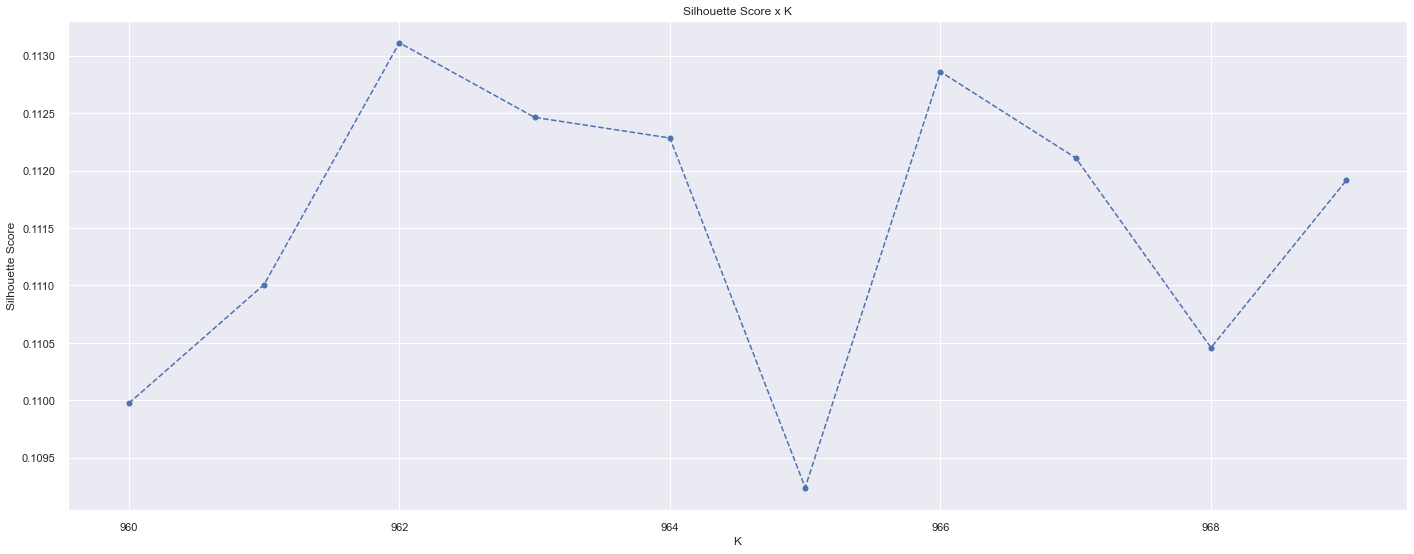

In [350]:
plt.plot( K, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

In [351]:
sorted(list(zip(K, kmeans_list)), key = lambda x: (x[1]))

[(965, 0.10923971473018075),
 (960, 0.10997395149633647),
 (968, 0.11045821365049154),
 (961, 0.1110078749234751),
 (969, 0.11191428529318295),
 (967, 0.11211079778021076),
 (964, 0.11228420639213794),
 (963, 0.11246393716639375),
 (966, 0.11286161973236332),
 (962, 0.11311345064459193)]

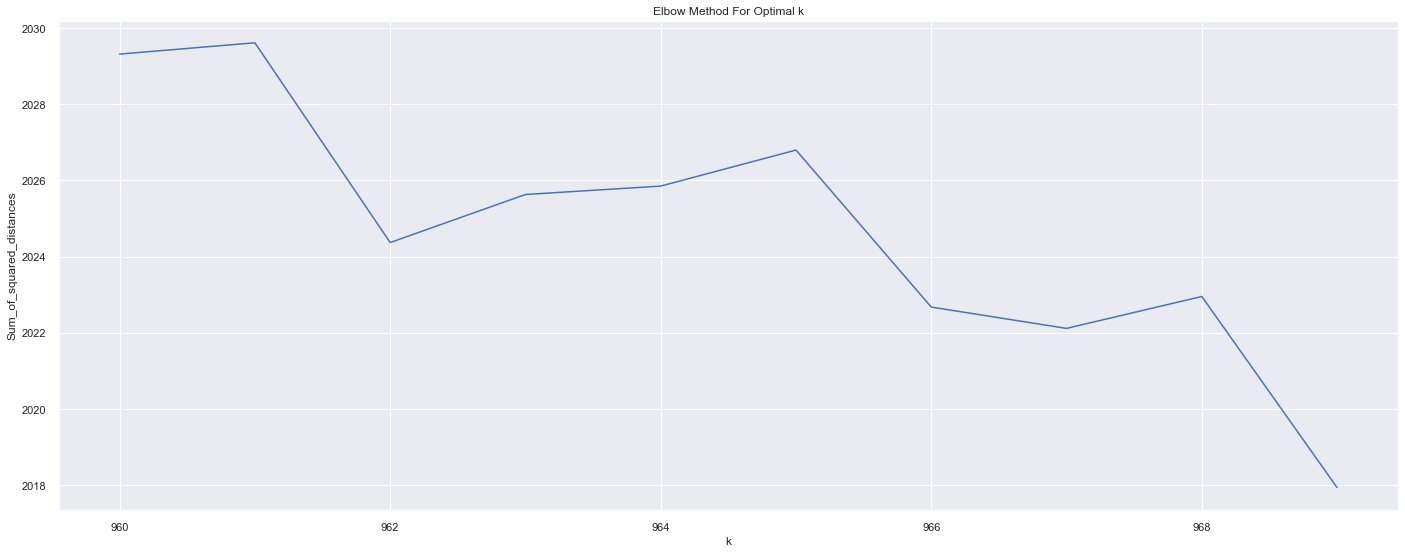

In [352]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
true_k = 962
model = KMeans(n_clusters=true_k)
model.fit(X)
labels=model.labels_

###### CLUSTER - DESCRIPTION

In [38]:
text_cl=pd.DataFrame(list(zip(text,labels)),columns=['description','cluster'])
#print(text_cl.sort_values(by=['cluster']))

In [39]:
len(text_cl['cluster'].unique())

962

In [45]:
text_cl.head()

description  cluster
0   white hanging heart t-light holder      905
1                  white metal lantern      923
2       cream cupid hearts coat hanger      120
3  knitted union flag hot water bottle       25
4       red woolly hottie white heart.       78

In [46]:
a = text_cl[['cluster','description']].groupby('cluster').count().sort_values('description', ascending=False).reset_index()
a#.groupby('title').count()

cluster  description
0        539           29
1         90           25
2         13           24
3        853           21
4         25           20
5        388           19
6        470           18
7         84           17
8        905           16
9         80           16
10       356           14
11       335           13
12         9           13
13        20           12
14       514           12
15       516           11
16       700           11
17       130           11
18       428           11
19         8           11
20        57           11
21        24           11
22       123           11
23       343           11
24       446           11
25        42           10
26       189           10
27       873           10
28       340           10
29        54           10
30        60           10
31         6           10
32       532           10
33        79           10
34       214           10
35       134           10
36        77            9
37       558            9
38        37            9
39       947            9
40       247            9
41       219            9
42       122            8
43        61            8
44       334            8
45       288            8
46        81            8
47       108            8
48       177            8
49       321            8
50       217            8
51       304            8
52       265            8
53       749            8
54       163            8
55       463            8
56       271            8
57       418            8
58       362            8
59       397            7
60       493            7
61       417            7
62       148            7
63       111            7
64       133            7
65       140            7
66        87            7
67       376            7
68       450            7
69       105            7
70       349            7
71        96            7
72       374            7
73       373            7
74       548            7
75       127            7
76       284            7
77        56            7
78        32            7
79       327            7
80       301            7
81        46            7
82       614            7
83       305            7
84       726            7
85       596            7
86       706            7
87       736            7
88       775            7
89       168            7
90       235            7
91       173            7
92       233            7
93       918            7
94       139            6
95       207            6
96       378            6
97       251            6
98       212            6
99       222            6
100      213            6
101      398            6
102      390            6
103      391            6
104      258            6
105      240            6
106      241            6
107      333            6
108      262            6
109      278            6
110      169            6
111      170            6
112      172            6
113      128            6
114      175            6
115      320            6
116      338            6
117      178            6
118      182            6
119      157            6
120      303            6
121      354            6
122      191            6
123      150            6
124      285            6
125      358            6
126      280            6
127      380            6
128      112            6
129      828            6
130      615            6
131       99            6
132      715            6
133      656            6
134      710            6
135      806            6
136       23            6
137       88            6
138       41            6
139       86            6
140       83            6
141       78            6
142      540            6
143       66            6
144      523            6
145       16            6
146      648            6
147      618            6
148      102            6
149      427            6
150       49            6
151      118            6
152      117            6
1

In [48]:
text_cl[text_cl['cluster']==539]

description  cluster
81           airline lounge,metal sign      539
89     you're confusing me metal sign       539
90          cook with wine metal sign       539
237      ladies & gentlemen metal sign      539
240                bathroom metal sign      539
242                  toilet metal sign      539
243    metal sign take it or leave it       539
244          i'm on holiday metal sign      539
443              metal sign empire tea      539
482                washroom metal sign      539
672            no junk mail metal sign      539
714              no singing metal sign      539
788                 garden metal sign       539
905             laundry 15c metal sign      539
1004     beware of the cat metal sign       539
1005  pottering in the shed metal sign      539
1267         area patrolled metal sign      539
1345                 party metal sign       539
1721                man flu metal sign      539
1751           more butter metal sign       539
1919        house wrecking metal sign       539
1960               way out metal sign       539
2142              bathroom metal sign       539
2474         old doc russel metal sign      539
2767     lighthouse printed metal sign      539
2997    toilet sign occupied or vacant      539
3071            open closed metal sign      539
3431   psychedelic metal sign calendar      539
3542        metal sign drop your pants      539

In [40]:
# creating columns for each cluster created
text_cl_n = text_cl.copy()
for i in range(len(text_cl['cluster'].unique())):
    class_ = "class_" + str(i)
    text_cl_n[class_] = text_cl_n.apply(lambda x: 1 if x['cluster'] == i else 0, axis=1)

In [41]:
# merging the to df4 and insertint the unit_price on it
aux = df4[['description', 'unit_price']]
aux = aux.drop_duplicates(subset='description')
text_cl_t = pd.merge(text_cl_n, aux, on='description', how='left')
for i in range(len(text_cl['cluster'].unique())):
    class_ = "class_" + str(i)
    text_cl_t[class_] = text_cl_t.apply(lambda x: x['unit_price'] if x[class_] == 1 else 0, axis=1)
text_cl_t = text_cl_t.drop(['cluster', 'unit_price'], axis=1)
df4_ = pd.merge(df4, text_cl_t, on='description', how='left')

# calculation the gross revenue for each class
for i in range(len(text_cl['cluster'].unique())):
    class_ = "class_" + str(i)
    df4_[class_] = df4_[class_] * df4_['quantity']

In [44]:
df4_[df4_['class_0'] > 0].head()

invoice_no stock_code  quantity invoice_date  unit_price         country               description  customer_id  gross_revenue  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_3

In [43]:
text_cl_t.shape

(3787, 963)

In [45]:
df4 = df4_.copy()

### 4.2.4 Invoice Date

In [46]:
#taking min / max buying date by customer
date_min = df4[['customer_id', 'invoice_date']].groupby('customer_id').min().reset_index().rename(columns={'invoice_date': 'first_buy_date'})
date_max = df4[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns={'invoice_date': 'last_buy_date'})

#total buy adjusted - removing returned and manual values from the gross amount
aux2 = df4[['customer_id', 'gross_revenue', 'total_returned', 'manual_p']].copy()
aux2['gross_revenue_adj'] = aux2['gross_revenue'] + aux2['total_returned'] + aux2['manual_p']
total_buy_adj = aux2[['customer_id', 'gross_revenue_adj']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue_adj': 'total_gross_revenue_adj'})

# buy frequency by customer
aux = df4[['customer_id', 'invoice_no']].drop_duplicates(subset='invoice_no')
buy_frequency = aux.groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'total_invoices'})

#joing the tables
df_date = pd.merge(date_min, date_max, on='customer_id', how='left')
df_date = pd.merge(df_date, buy_frequency, on='customer_id', how='left')
df_date = pd.merge(df_date, total_buy_adj, on='customer_id', how='left')

df_date['date_interval'] = df_date['last_buy_date'] - df_date['first_buy_date']
df_date['date_interval'] = df_date['date_interval'].apply(lambda x: x.days)
df_date['date_interval'] = df_date['date_interval'].apply(lambda x: 0 if x==0 else x)
df_date['buy_rate'] = df_date['date_interval'] / df_date['total_invoices']
df_date['customer_by_day'] = df_date['total_gross_revenue_adj'] / df_date['date_interval']
df_date.replace([np.inf, -np.inf], 0, inplace=True)
df_date = df_date.drop(columns=['first_buy_date', 'last_buy_date'])

In [47]:
df_date.sort_values('customer_by_day', ascending=False).head(30)

customer_id  total_invoices  total_gross_revenue_adj  date_interval  buy_rate  customer_by_day
4259        18139               8                  8393.22              1      0.12          8393.22
3428        16986               2                  1873.20              1      0.50          1873.20
3798        17509              11                  6100.74              6      0.55          1016.79
1702        14646              74                278466.02            353      4.77           788.86
4255        18133               2                   715.50              1      0.50           715.50
4232        18102              62                256438.49            367      5.92           698.74
2483        15700               3                   664.03              1      0.33           664.03
1880        14893               2                  1237.85              2      1.00           618.93
2207        15332               4                  1661.06              3      0.75           553.69
1299        14096              18                 53147.98             97      5.39           547.92
3757        17450              51                188420.57            359      7.04           524.85
3712        17391               2                   508.80              1      0.50           508.80
198         12590               2                  9338.38             21     10.50           444.68
2130        15230               2                   429.60              1      0.50           429.60
628         13166               2                   414.70              1      0.50           414.70
1438        14288               2                   413.85              1      0.50           413.85
55          12415              24                123638.18            313     13.04           395.01
2647        15922               2                   363.60              1      0.50           363.60
1894        14911             248                132572.62            372      1.50           356.38
1344        14156              66                113384.14            363      5.50           312.35
1997        15060               4                   303.09              1      0.25           303.09
3477        17053               2                   496.38              2      1.00           248.19
2074        15154               2                   240.27              1      0.50           240.27
3800        17511              45                 88127.55            371      8.24           237.54
2521        15749               4                 21535.90             97     24.25           222.02
3902        17649               2                   861.74              4      2.00           215.44
1321        14126               4                   643.63              3      0.75           214.54
2653        15935               2                   416.86              2      1.00           208.43
812         13422               2                  2601.55             13      6.50           200.12
2791        16124               2                   187.15              1      0.50           187.15

### 4.2.5 Products with no meaning (previous cicles)

In [48]:
#All the products bellow do not have enough representative 
to_remove_code = ['M','m','23113','23114','23117','23115','23116','84968E','21275','20818','90159','84805B','35598C']

In [49]:
# dropping records do not have total of sum > 0
df4_=df4[~df4['stock_code'].isin(to_remove_code)]
df4_.shape

(536094, 973)

In [228]:
## inserting values to the new created columns
#for i in range(df4_.iloc[:, 12:813].shape[1]):
#    df4_.iloc[:, i+12] = df4_['unit_price_adj']*df4_['quantity']*df4_.iloc[:, i+12]

In [50]:
df4 = df4_.copy()

#### 4.3 FINAL DATASET - SPACE STUDY

In [138]:
df4_ = df4.drop(columns=['stock_code', 'description', 'country', 'gross_revenue']).copy()

In [139]:
df4_ = df4_.groupby(['customer_id', 'invoice_no']).sum().reset_index()
df4_ = pd.merge(df4_, df_postal, on='invoice_no', how='left' )
df4_['total_postal'] = df4_.apply(lambda x: x['total_postal'] if x['total_postal'] > 0 else 0, axis=1)

In [140]:
df4_ = df4_.groupby('customer_id').sum().reset_index()
df4_ = pd.merge(df4_, df_date, on='customer_id', how='left')
df4_ = df4_[df4_['total_gross_revenue_adj'] > 0]

In [141]:
df4_.head()

customer_id  quantity  unit_price  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_359  class_360  class_361  class_362  class_363  class_364  class_365  class_366  class_367  c

In [77]:
X = df4_.copy()
X = X.drop(columns=['customer_id'])
for i in range(X.shape[1]):
    mm = pp.MinMaxScaler()
    X.iloc[:, i] = mm.fit_transform(X.iloc[:, i].values.reshape(-1, 1))

In [79]:
X.head()

quantity  unit_price  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_359  class_360  class_361  class_362  class_363  class_364  class_365  class_366  class_367  class_368  cla

## 4.4. SPACE STUDY

##### PCA

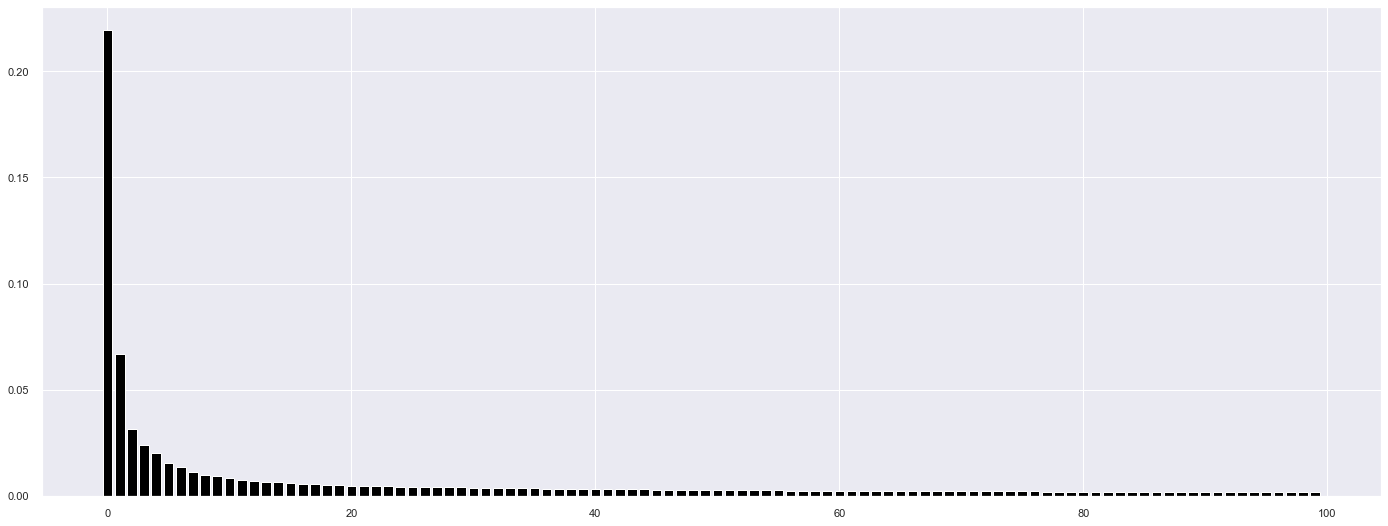

In [80]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features[:100], pca.explained_variance_ratio_[:100], color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

In [81]:
dfx = pd.DataFrame([features, pca.explained_variance_ratio_])

In [82]:
dfx = dfx.T
dfx['sum'] = dfx.iloc[:,1].cumsum()
dfx

0    1  sum
0     0.00 0.22 0.22
1     1.00 0.07 0.29
2     2.00 0.03 0.32
3     3.00 0.02 0.34
4     4.00 0.02 0.36
5     5.00 0.02 0.38
6     6.00 0.01 0.39
7     7.00 0.01 0.40
8     8.00 0.01 0.41
9     9.00 0.01 0.42
10   10.00 0.01 0.43
11   11.00 0.01 0.44
12   12.00 0.01 0.44
13   13.00 0.01 0.45
14   14.00 0.01 0.46
15   15.00 0.01 0.46
16   16.00 0.01 0.47
17   17.00 0.01 0.47
18   18.00 0.01 0.48
19   19.00 0.00 0.48
20   20.00 0.00 0.49
21   21.00 0.00 0.49
22   22.00 0.00 0.50
23   23.00 0.00 0.50
24   24.00 0.00 0.51
25   25.00 0.00 0.51
26   26.00 0.00 0.52
27   27.00 0.00 0.52
28   28.00 0.00 0.52
29   29.00 0.00 0.53
30   30.00 0.00 0.53
31   31.00 0.00 0.54
32   32.00 0.00 0.54
33   33.00 0.00 0.54
34   34.00 0.00 0.55
35   35.00 0.00 0.55
36   36.00 0.00 0.55
37   37.00 0.00 0.56
38   38.00 0.00 0.56
39   39.00 0.00 0.56
40   40.00 0.00 0.57
41   41.00 0.00 0.57
42   42.00 0.00 0.57
43   43.00 0.00 0.58
44   44.00 0.00 0.58
45   45.00 0.00 0.58
46   46.00 0.00 0.58
47   47.00 0.00 0.59
48   48.00 0.00 0.59
49   49.00 0.00 0.59
50   50.00 0.00 0.59
51   51.00 0.00 0.60
52   52.00 0.00 0.60
53   53.00 0.00 0.60
54   54.00 0.00 0.61
55   55.00 0.00 0.61
56   56.00 0.00 0.61
57   57.00 0.00 0.61
58   58.00 0.00 0.61
59   59.00 0.00 0.62
60   60.00 0.00 0.62
61   61.00 0.00 0.62
62   62.00 0.00 0.62
63   63.00 0.00 0.63
64   64.00 0.00 0.63
65   65.00 0.00 0.63
66   66.00 0.00 0.63
67   67.00 0.00 0.64
68   68.00 0.00 0.64
69   69.00 0.00 0.64
70   70.00 0.00 0.64
71   71.00 0.00 0.64
72   72.00 0.00 0.65
73   73.00 0.00 0.65
74   74.00 0.00 0.65
75   75.00 0.00 0.65
76   76.00 0.00 0.65
77   77.00 0.00 0.66
78   78.00 0.00 0.66
79   79.00 0.00 0.66
80   80.00 0.00 0.66
81   81.00 0.00 0.66
82   82.00 0.00 0.67
83   83.00 0.00 0.67
84   84.00 0.00 0.67
85   85.00 0.00 0.67
86   86.00 0.00 0.67
87   87.00 0.00 0.68
88   88.00 0.00 0.68
89   89.00 0.00 0.68
90   90.00 0.00 0.68
91   91.00 0.00 0.68
92   92.00 0.00 0.68
93   93.00 0.00 0.69
94   94.00 0.00 0.69
95   95.00 0.00 0.69
96   96.00 0.00 0.69
97   97.00 0.00 0.69
98   98.00 0.00 0.70
99   99.00 0.00 0.70
100 100.00 0.00 0.70
101 101.00 0.00 0.70
102 102.00 0.00 0.70
103 103.00 0.00 0.70
104 104.00 0.00 0.71
105 105.00 0.00 0.71
106 106.00 0.00 0.71
107 107.00 0.00 0.71
108 108.00 0.00 0.71
109 109.00 0.00 0.71
110 110.00 0.00 0.71
111 111.00 0.00 0.72
112 112.00 0.00 0.72
113 113.00 0.00 0.72
114 114.00 0.00 0.72
115 115.00 0.00 0.72
116 116.00 0.00 0.72
117 117.00 0.00 0.73
118 118.00 0.00 0.73
119 119.00 0.00 0.73
120 120.00 0.00 0.73
121 121.00 0.00 0.73
122 122.00 0.00 0.73
123 123.00 0.00 0.73
124 124.00 0.00 0.74
125 125.00 0.00 0.74
126 126.00 0.00 0.74
127 127.00 0.00 0.74
128 128.00 0.00 0.74
129 129.00 0.00 0.74
130 130.00 0.00 0.74
131 131.00 0.00 0.74
132 132.00 0.00 0.75
133 133.00 0.00 0.75
134 134.00 0.00 0.75
135 135.00 0.00 0.75
136 136.00 0.00 0.75
137 137.00 0.00 0.75
138 138.00 0.00 0.75
139 139.00 0.00 0.76
140 140.00 0.00 0.76
141 141.00 0.00 0.76
142 142.00 0.00 0.76
143 143.00 0.00 0.76
144 144.00 0.00 0.76
145 145.00 0.00 0.76
146 146.00 0.00 0.76
147 147.00 0.00 0.77
148 148.00 0.00 0.77
149 149.00 0.00 0.77
150 150.00 0.00 0.77
151 151.00 0.00 0.77
152 152.00 0.00 0.77
153 153.00 0.00 0.77
154 154.00 0.00 0.77
155 155.00 0.00 0.78
156 156.00 0.00 0.78
157 157.00 0.00 0.78
158 158.00 0.00 0.78
159 159.00 0.00 0.78
160 160.00 0.00 0.78
161 161.00 0.00 0.78
162 162.00 0.00 0.78
163 163.00 0.00 0.78
164 164.00 0.00 0.79
165 165.00 0.00 0.79
166 166.00 0.00 0.79
167 167.00 0.00 0.79
168 168.00 0.00 0.79
169 169.00 0.00 0.79
170 170.00 0.00 0.79
171 171.00 0.00 0.79
172 172.00 0.00 0.79
173 173.00 0.00 0.80
174 174.00 0.00 0.80
175 175.00 0.00 0.80
176 176.00 0.00 0.80
177 177.00 0.00 0.80
178 178.00 0.00 0.80
179 179.00 0.00 0.80
180 180.00 0.00 0.80
181 181.00 0.00 0.80
182 182.00 0.00 0.80
183 183.00 0.00 0.81
184 184.00 0.00 0.81
185 185.00 0.00 0.81
186 186.00 0.00 0.81
187 187.00 0.00 0.81
188 188.00 0.00 0.81
189 189.00 0.00 0.8

In [83]:
df_pca = df_pca.rename(columns={0:'x', 1: 'y'})

<AxesSubplot:xlabel='x', ylabel='y'>

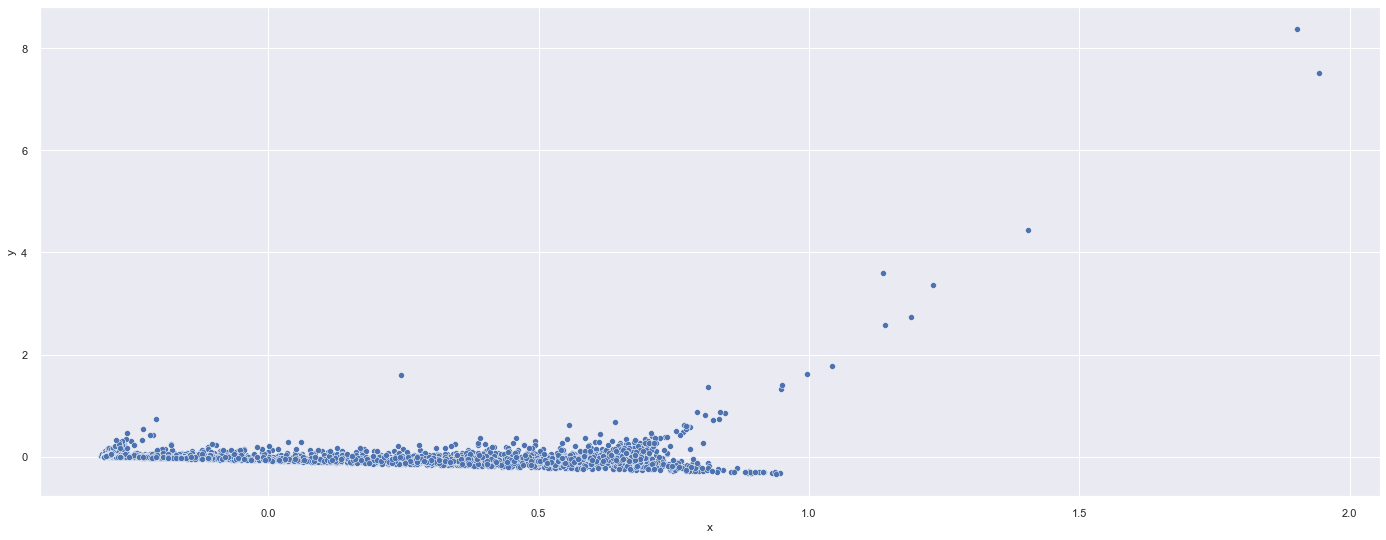

In [84]:
sns.scatterplot( x='x', y='y', data=df_pca)

###### UMAP

In [152]:
reducer

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

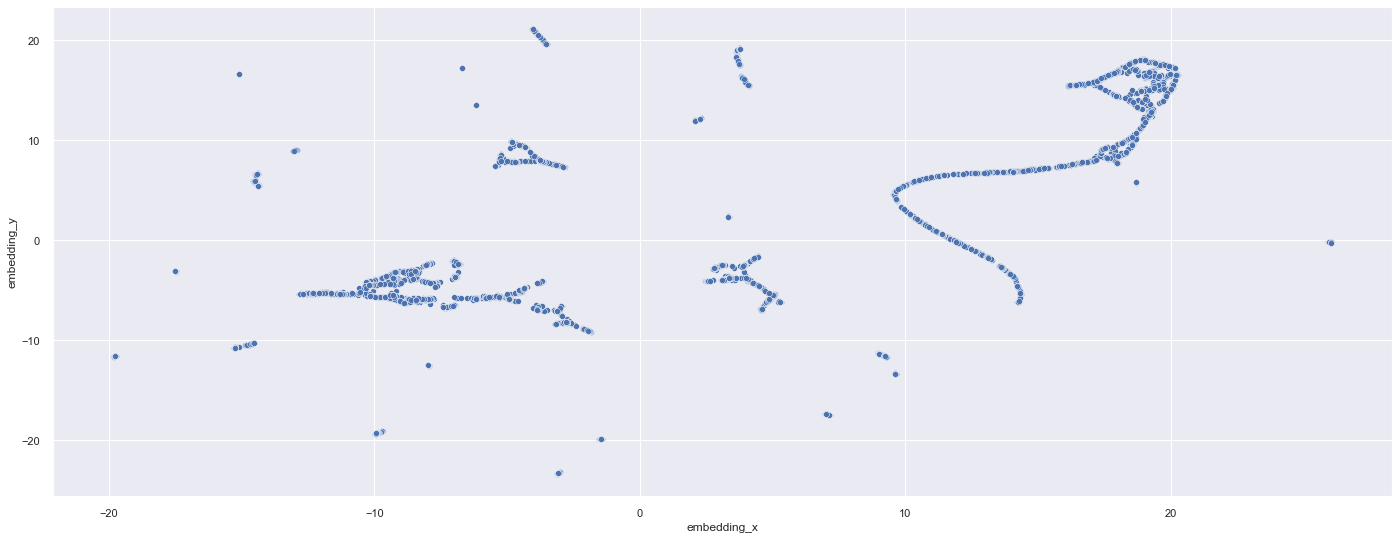

In [201]:
reducer = umap.UMAP( random_state=42, 
                     n_neighbors=2000,
                     min_dist=0.1,
                     n_components=2,
                     metric='euclidean' )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

##### t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

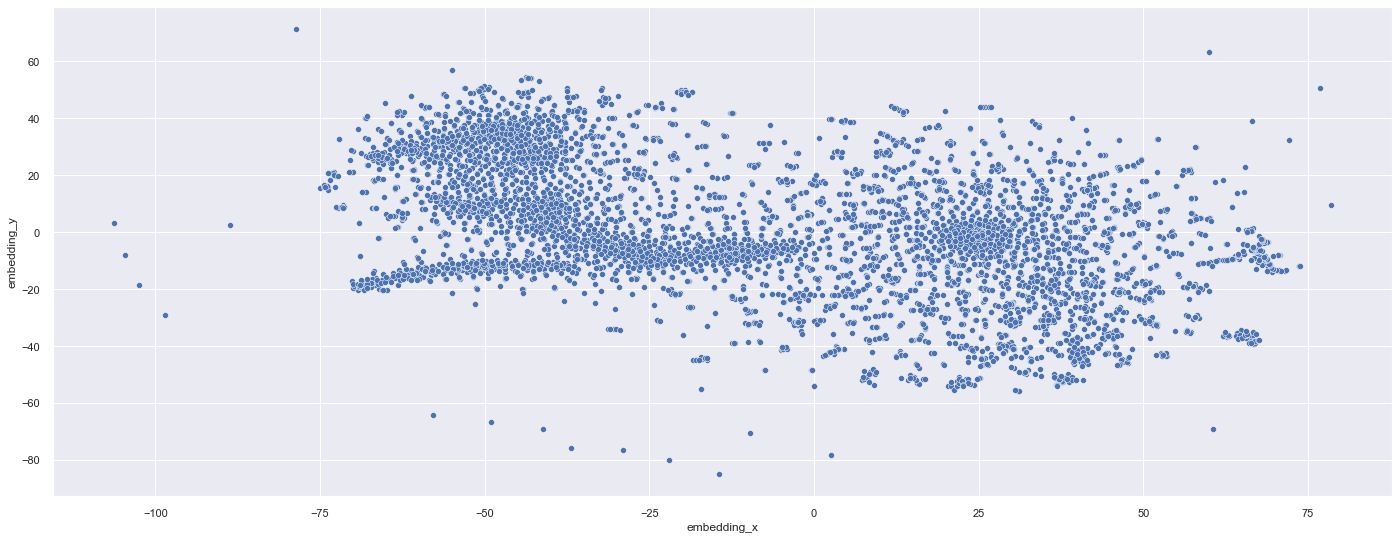

In [94]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

#### Tree-Based Embedding

In [90]:
# training dataset
X_ = X.drop( columns=['total_gross_revenue_adj'], axis=1 )
y = X['total_gross_revenue_adj']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X_, y )

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [91]:
df_leaf = pd.DataFrame( rf_model.apply( X_ ) )

D:\Anaconda\programa\envs\DS_PA005\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

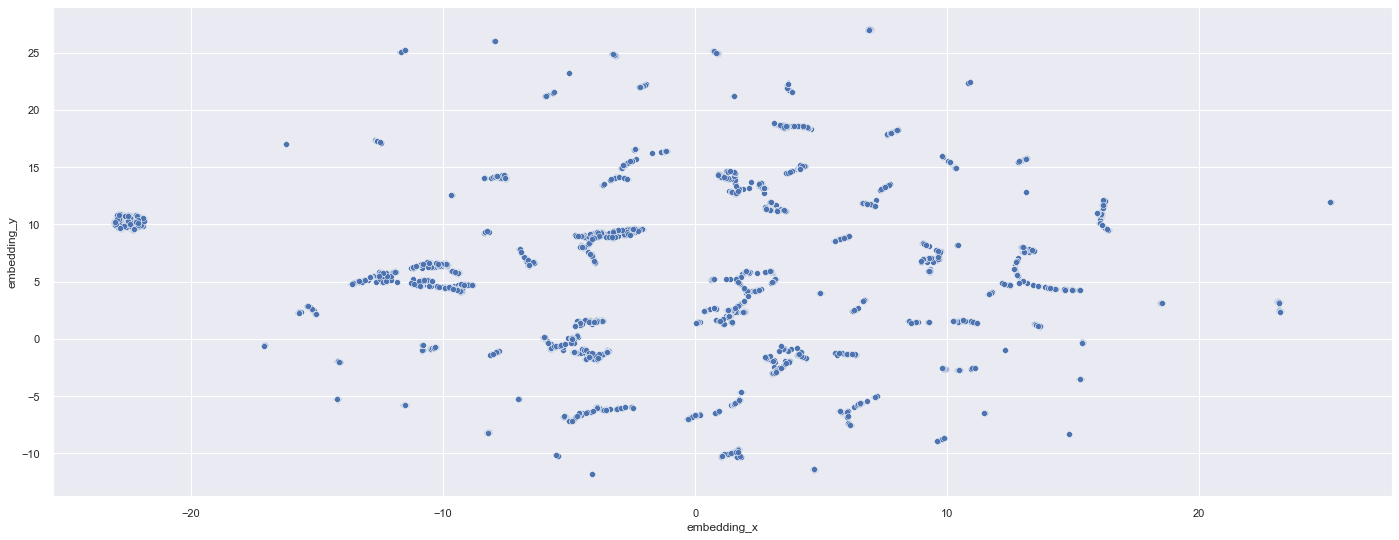

In [92]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

In [244]:
df_tree.shape

(5693, 2)

# <font color='red'> 5.0. Data Preparation </font>

In [245]:
df5 = df_tree.copy()
df5.head()

embedding_x  embedding_y
0        -4.50         8.04
1       -14.17        -5.31
2        -3.09        -6.09
3       -14.16        -1.97
4         7.01        11.74

## 5.1. NORMALIZATION

## 5.2. RESCALLING

## 5.3. TRANSFORMATION

# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [246]:
X = df5.copy()

In [252]:
clusters = range(2, 100)
#[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ]

In [163]:
X.shape

(5693, 2)

## 7.1. Defining the number of Clusers - K-Means

In [253]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)
    print('Cluster:', k)

Cicle: 2
Cicle: 3
Cicle: 4
Cicle: 5
Cicle: 6
Cicle: 7
Cicle: 8
Cicle: 9
Cicle: 10
Cicle: 11
Cicle: 12
Cicle: 13
Cicle: 14
Cicle: 15
Cicle: 16
Cicle: 17
Cicle: 18
Cicle: 19
Cicle: 20
Cicle: 21
Cicle: 22
Cicle: 23
Cicle: 24
Cicle: 25
Cicle: 26
Cicle: 27
Cicle: 28
Cicle: 29
Cicle: 30
Cicle: 31
Cicle: 32
Cicle: 33
Cicle: 34
Cicle: 35
Cicle: 36
Cicle: 37
Cicle: 38
Cicle: 39
Cicle: 40
Cicle: 41
Cicle: 42
Cicle: 43
Cicle: 44
Cicle: 45
Cicle: 46
Cicle: 47
Cicle: 48
Cicle: 49
Cicle: 50
Cicle: 51
Cicle: 52
Cicle: 53
Cicle: 54
Cicle: 55
Cicle: 56
Cicle: 57
Cicle: 58
Cicle: 59
Cicle: 60
Cicle: 61
Cicle: 62
Cicle: 63
Cicle: 64
Cicle: 65
Cicle: 66
Cicle: 67
Cicle: 68
Cicle: 69
Cicle: 70
Cicle: 71
Cicle: 72
Cicle: 73
Cicle: 74
Cicle: 75
Cicle: 76
Cicle: 77
Cicle: 78
Cicle: 79
Cicle: 80
Cicle: 81
Cicle: 82
Cicle: 83
Cicle: 84
Cicle: 85
Cicle: 86
Cicle: 87
Cicle: 88
Cicle: 89
Cicle: 90
Cicle: 91
Cicle: 92
Cicle: 93
Cicle: 94
Cicle: 95
Cicle: 96
Cicle: 97
Cicle: 98
Cicle: 99


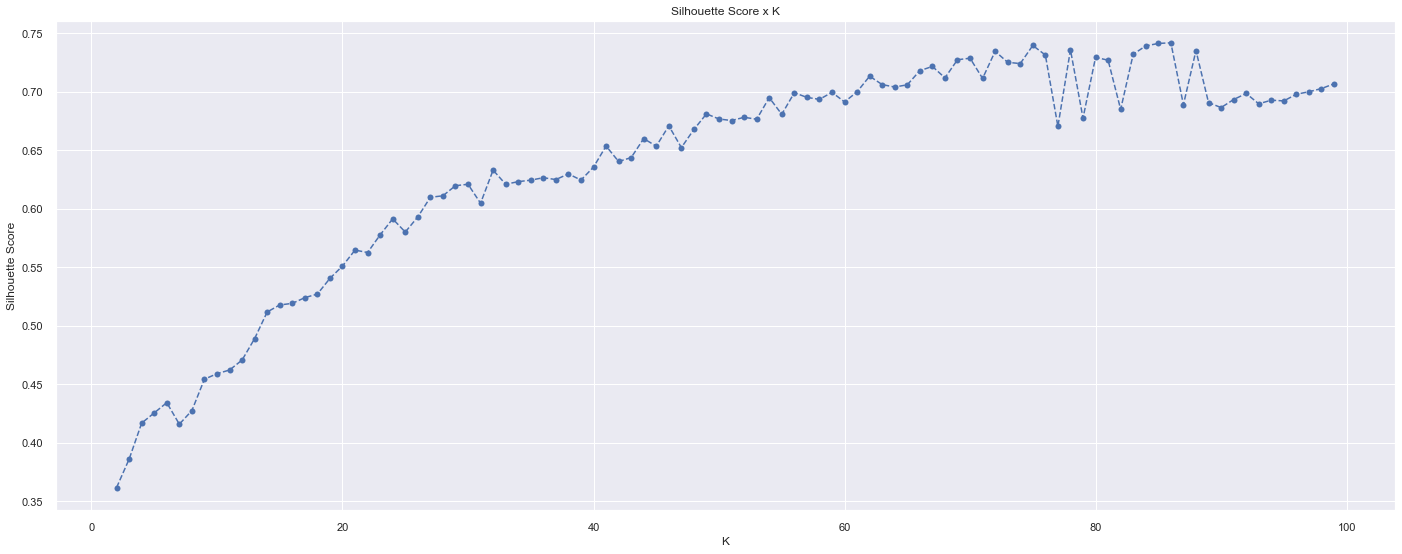

In [254]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [255]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )
    print('Cluster:', k)

Cicle: 2
Cicle: 3
Cicle: 4
Cicle: 5
Cicle: 6
Cicle: 7
Cicle: 8
Cicle: 9
Cicle: 10
Cicle: 11
Cicle: 12
Cicle: 13
Cicle: 14
Cicle: 15
Cicle: 16
Cicle: 17
Cicle: 18
Cicle: 19
Cicle: 20
Cicle: 21
Cicle: 22
Cicle: 23
Cicle: 24
Cicle: 25
Cicle: 26
Cicle: 27
Cicle: 28
Cicle: 29
Cicle: 30
Cicle: 31
Cicle: 32
Cicle: 33
Cicle: 34
Cicle: 35
Cicle: 36
Cicle: 37
Cicle: 38
Cicle: 39
Cicle: 40
Cicle: 41
Cicle: 42
Cicle: 43
Cicle: 44
Cicle: 45
Cicle: 46
Cicle: 47
Cicle: 48
Cicle: 49
Cicle: 50
Cicle: 51
Cicle: 52
Cicle: 53
Cicle: 54
Cicle: 55
Cicle: 56
Cicle: 57
Cicle: 58
Cicle: 59
Cicle: 60
Cicle: 61
Cicle: 62
Cicle: 63
Cicle: 64
Cicle: 65
Cicle: 66
Cicle: 67
Cicle: 68
Cicle: 69
Cicle: 70
Cicle: 71
Cicle: 72
Cicle: 73
Cicle: 74
Cicle: 75
Cicle: 76
Cicle: 77
Cicle: 78
Cicle: 79
Cicle: 80
Cicle: 81
Cicle: 82
Cicle: 83
Cicle: 84
Cicle: 85
Cicle: 86
Cicle: 87
Cicle: 88
Cicle: 89
Cicle: 90
Cicle: 91
Cicle: 92
Cicle: 93
Cicle: 94
Cicle: 95
Cicle: 96
Cicle: 97
Cicle: 98
Cicle: 99


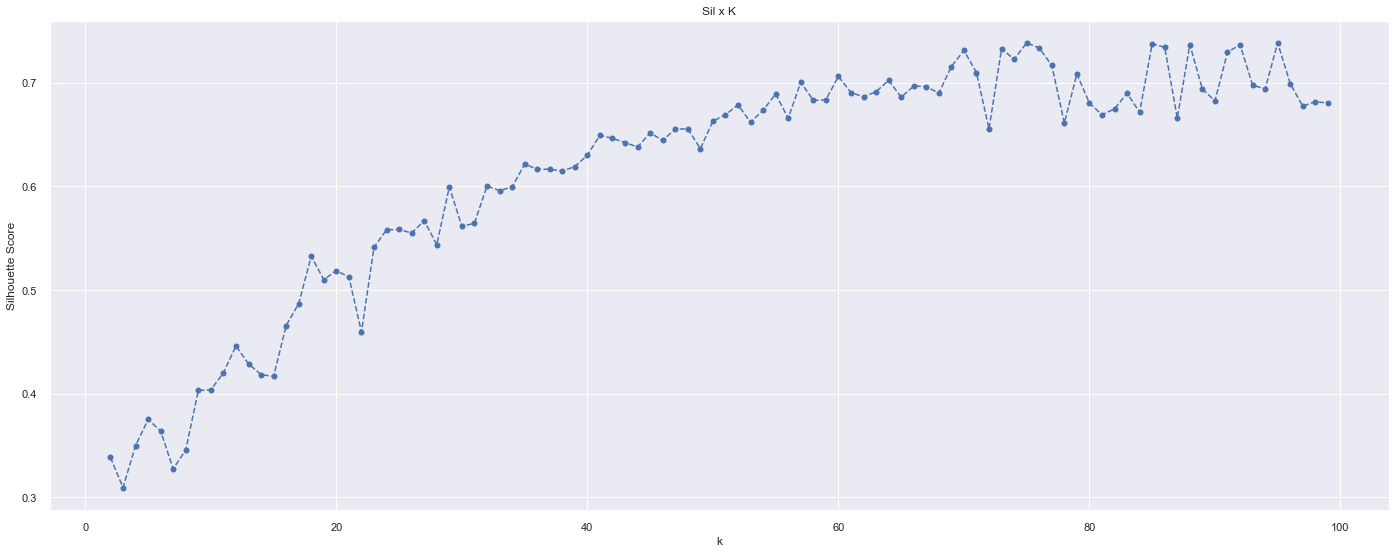

In [256]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [104]:
from scipy.cluster import hierarchy as hc

In [105]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

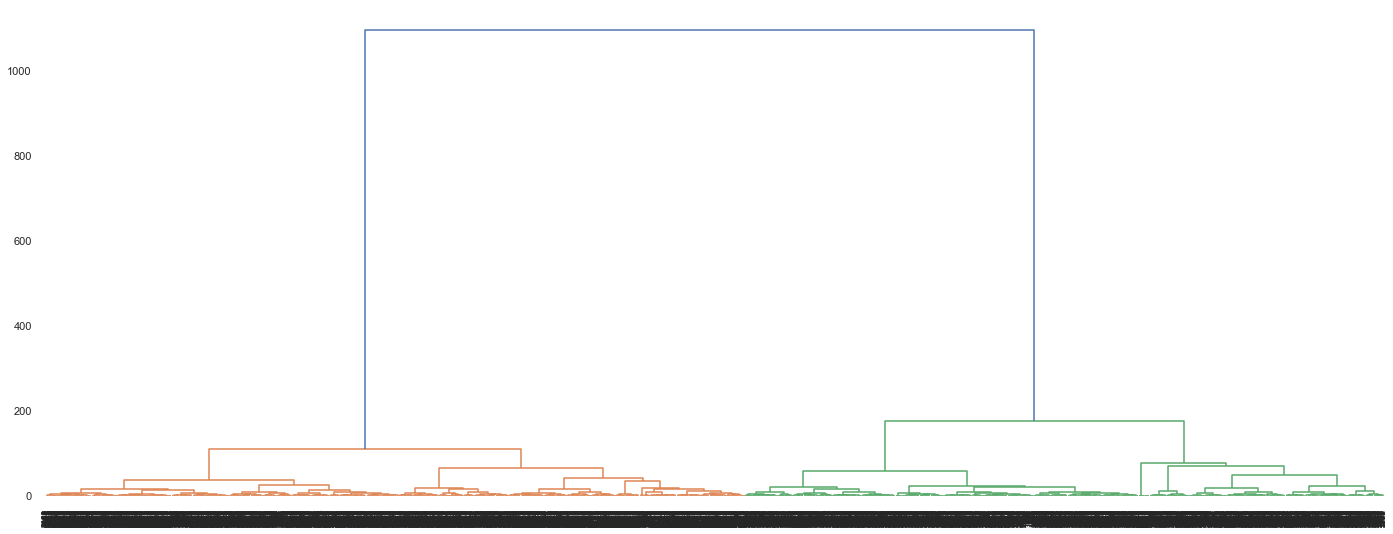

In [106]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

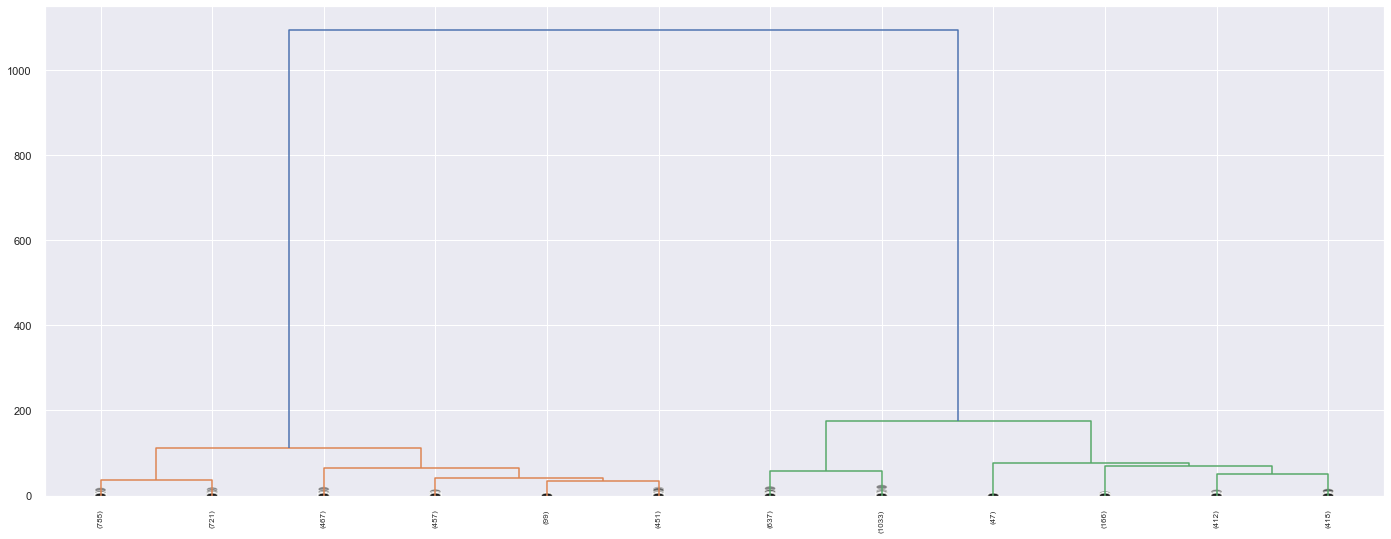

In [107]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [257]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )
    print('cluster', k)

cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
cluster 15
cluster 16
cluster 17
cluster 18
cluster 19
cluster 20
cluster 21
cluster 22
cluster 23
cluster 24
cluster 25
cluster 26
cluster 27
cluster 28
cluster 29
cluster 30
cluster 31
cluster 32
cluster 33
cluster 34
cluster 35
cluster 36
cluster 37
cluster 38
cluster 39
cluster 40
cluster 41
cluster 42
cluster 43
cluster 44
cluster 45
cluster 46
cluster 47
cluster 48
cluster 49
cluster 50
cluster 51
cluster 52
cluster 53
cluster 54
cluster 55
cluster 56
cluster 57
cluster 58
cluster 59
cluster 60
cluster 61
cluster 62
cluster 63
cluster 64
cluster 65
cluster 66
cluster 67
cluster 68
cluster 69
cluster 70
cluster 71
cluster 72
cluster 73
cluster 74
cluster 75
cluster 76
cluster 77
cluster 78
cluster 79
cluster 80
cluster 81
cluster 82
cluster 83
cluster 84
cluster 85
cluster 86
cluster 87
cluster 88
cluster 89
cluster 90
cluster 91
cluster 92
cluster

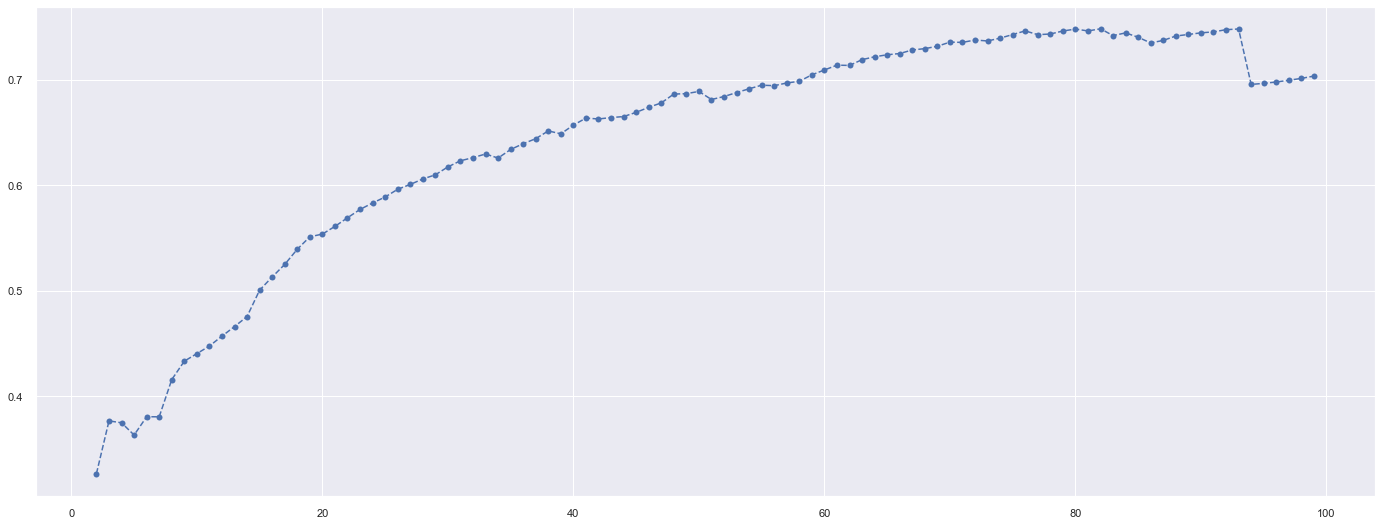

In [258]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [119]:
eps=1.5
min_samples=10

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.5820796489715576
Number of Clusters: 4
[0 1 2 3]


In [120]:
from sklearn.neighbors import NearestNeighbors

In [121]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

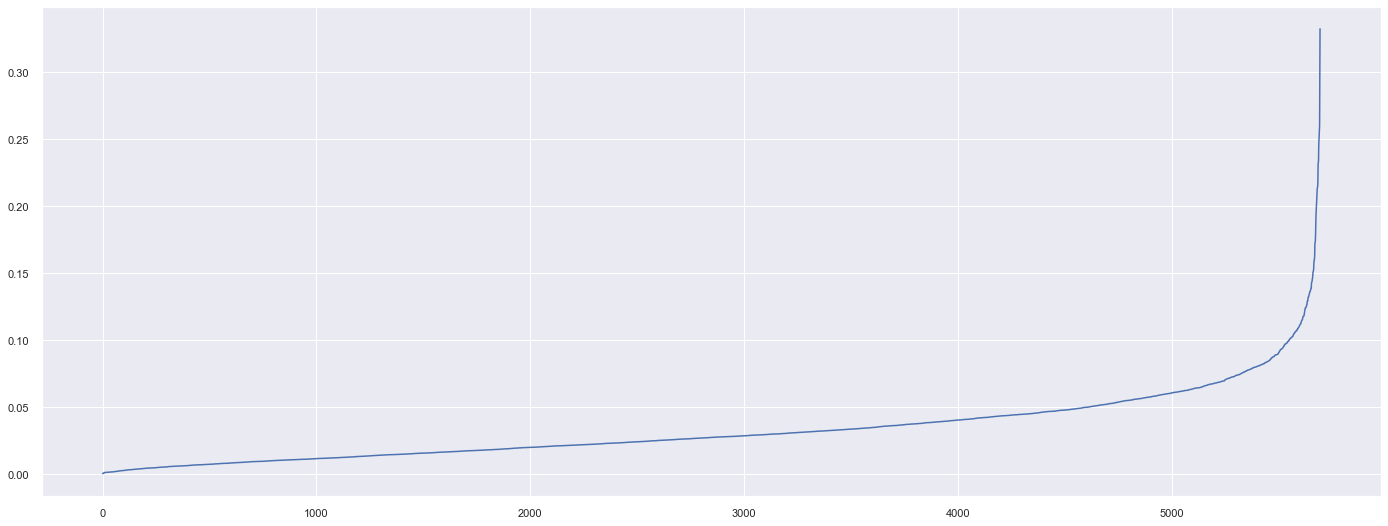

In [122]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

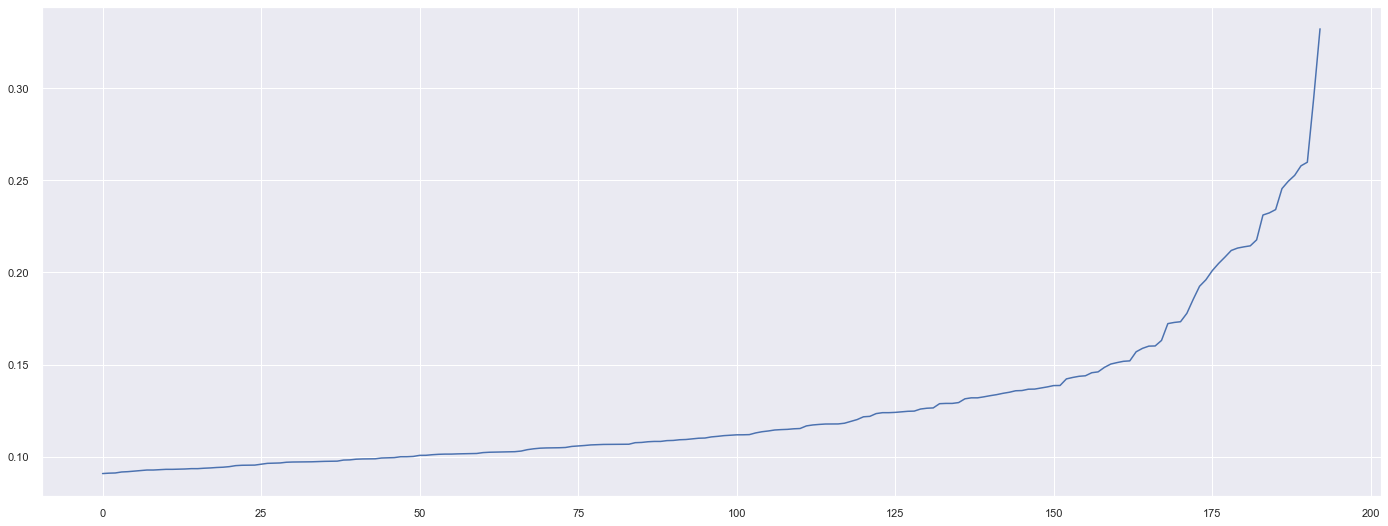

In [123]:
plt.plot( distances[5500:] )

In [38]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [259]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
     #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [260]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

## 7.6. Silhouette Analysis

 For K = 2. Silhouette Score: 0.6134214997291565
 For K = 3. Silhouette Score: 0.5467432737350464
 For K = 4. Silhouette Score: 0.4574434459209442
 For K = 5. Silhouette Score: 0.45421692728996277
 For K = 6. Silhouette Score: 0.4449106454849243
 For K = 7. Silhouette Score: 0.41292959451675415


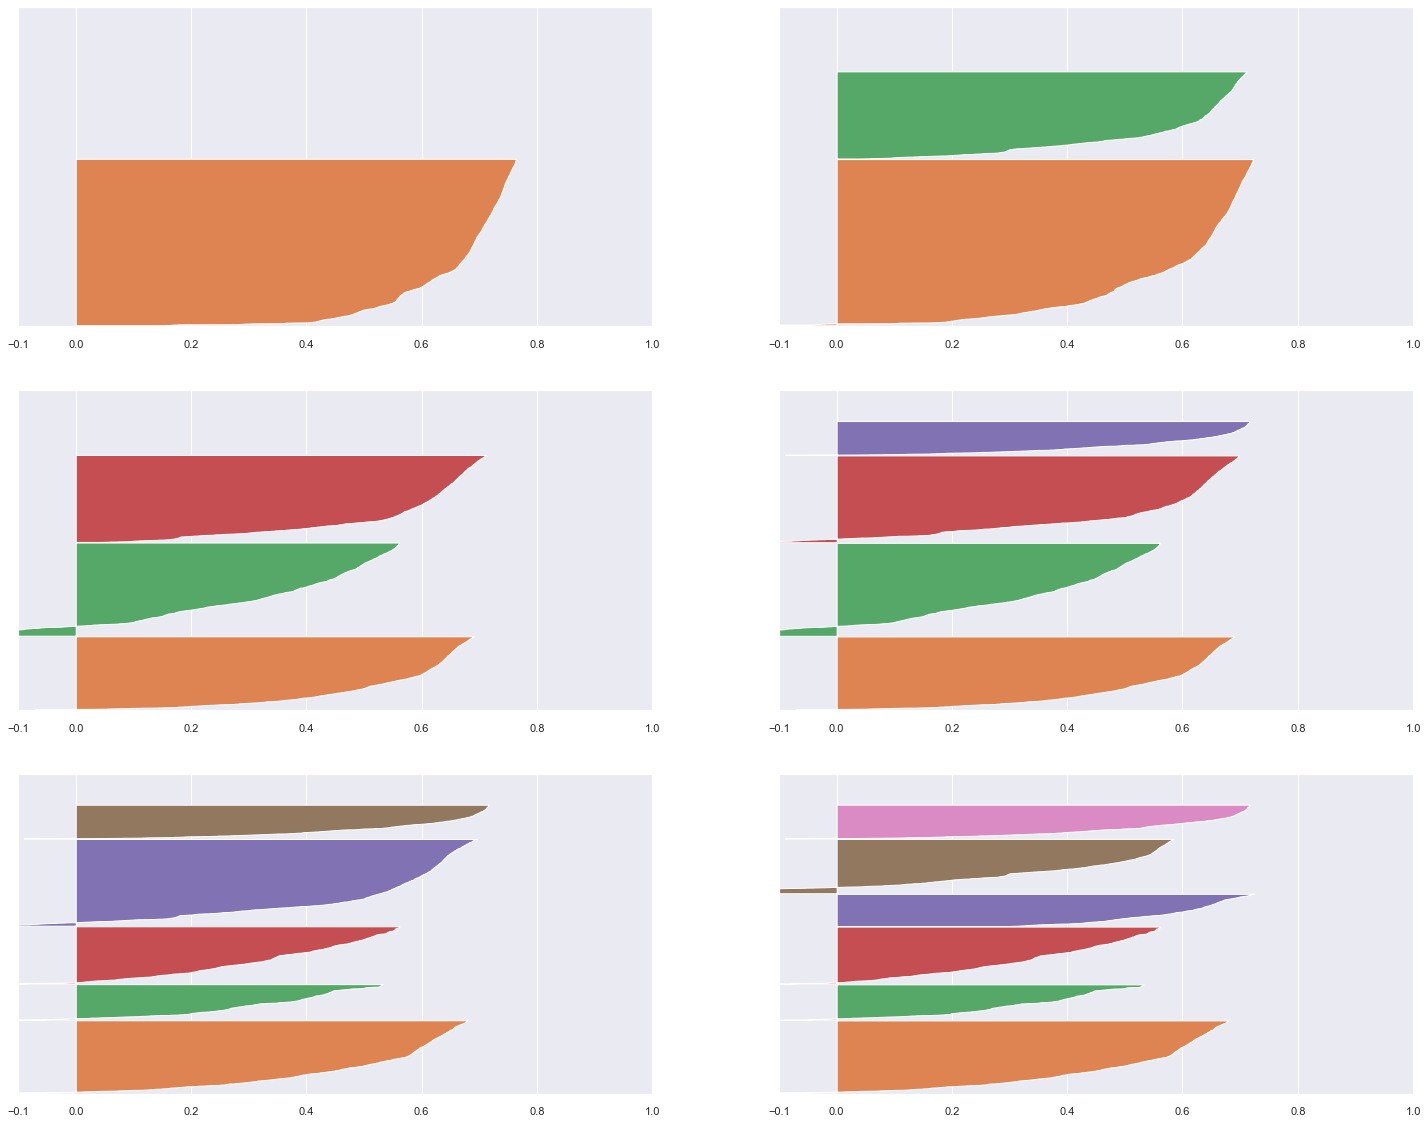

In [171]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [261]:
# model definition
k = 86
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [262]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 5035.048428240327
SS Values: 0.5916525721549988


# <font color='red'> 9.0. Cluster Analysis </font>

In [263]:
df9 = df4_.copy()
df9['cluster'] = labels
df9.head()

customer_id  quantity  unit_price  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_359  class_360  class_361  class_362  class_363  class_364  class_365  class_366  class_367  c

In [143]:
df9.shape

(5693, 974)

In [264]:
X_l = X.copy()
X_l['cluster'] = labels
X_l.head()

embedding_x  embedding_y  cluster
0        -4.50         8.04       19
1       -14.17        -5.31       77
2        -3.09        -6.09       68
3       -14.16        -1.97       77
4         7.01        11.74       53

## 9.1. Visualization Inspection

In [265]:
fig = px.scatter_3d(X_l, x='embedding_x', y='embedding_y', z='embedding_y', color='cluster')
fig.show()

## 9.2. 2d plot

D:\Anaconda\programa\envs\DS_PA005\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

D:\Anaconda\programa\envs\DS_PA005\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



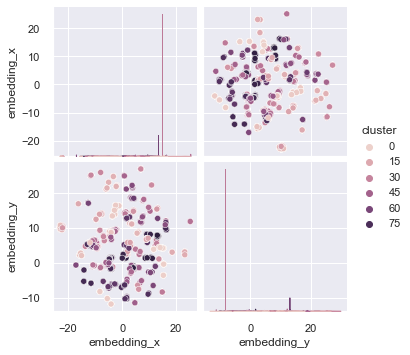

In [266]:
sns.pairplot( X_l, hue='cluster' )

## 9.1. Cluster Profile

In [230]:
df9.columns

Index(['customer_id', 'quantity', 'unit_price', 'unit_price_adj',
       'total_postal', 'total_invoice', 'total_invoices',
       'total_gross_revenue_adj', 'date_interval', 'buy_rate',
       'customer_by_day', 'cluster'],
      dtype='object')

In [267]:
df_cluster = pd.DataFrame()
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'total_customers'})
df_cluster['perc_customer'] = 100*(df_cluster['total_customers'] / df_cluster['total_customers'].sum())

# Avg quantity
df_avg_avg_qt = df9[['quantity', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_avg_qt, how='inner', on='cluster')

# Avg total postal
df_avg_total_postal = df9[['total_postal', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_total_postal, how='inner', on='cluster')

# Avg invoice
df_avg_invoice_no = df9[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg total_gross_revenue_adj
df_avg_gav_ajd = df9[['total_gross_revenue_adj', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg date_interval
df_avg_gav_ajd = df9[['date_interval', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg buy_rate
df_avg_gav_ajd = df9[['buy_rate', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg customer_by_day
df_avg_gav_ajd = df9[['customer_by_day', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

In [268]:
df_cluster.sort_values('customer_by_day', ascending=False)

cluster  total_customers  perc_customer  quantity  total_postal  total_invoices  total_gross_revenue_adj  date_interval  buy_rate  customer_by_day
64       64               31           0.54  33278.68         33.48           38.90                 58944.57         219.81      9.63           182.21
10       10               69           1.21   6607.30         84.35           20.64                  9575.60         286.04     19.00           151.22
59       59               57           1.00  11755.12         48.56           29.12                 16764.84         246.49     13.62            42.51
43       43              126           2.21   3506.76         59.94           15.69                  6737.58         268.56     21.36            37.88
39       39              135           2.37   1016.07         25.80            4.90                  1523.81         171.07     37.23            29.97
33       33               55           0.97    109.02          2.55            2.18                   239.27          45.33     18.08            28.89
85       85               63           1.11    161.60          4.79            2.38                   346.35          68.79     29.23            27.95
4         4               52           0.91   1355.37         16.88            5.15                  1692.90         184.98     34.40            27.32
26       26               67           1.18    763.13          9.13            3.73                  1252.89         129.25     35.52            26.09
40       40               28           0.49    365.43          4.29            2.39                   524.84          65.36     18.50            22.85
78       78               54           0.95    478.98         12.70            2.65                   659.24         103.74     34.14            19.98
50       50               55           0.97   2070.02         23.53            9.67                  3662.83         256.67     34.12            18.90
21       21               47           0.83    149.32          3.40            2.77                   445.35          98.57     37.11            15.92
48       48               59           1.04   1272.31         18.71            7.92                  2163.08         247.85     36.40            15.51
82       82               57           1.00    212.61          2.81            2.96                   514.58         126.40     43.12            15.20
49       49               50           0.88    184.86          2.76            2.26                   387.60          61.92     24.86            14.66
74       74               80           1.41    206.70          5.65            1.95                   375.10          59.69     25.12            13.11
60       60               13           0.23    448.08          4.15            3.46                   806.98         151.00     39.70            12.61
75       75               49           0.86   1483.55         44.55            5.47                  2099.20         208.20     45.14            12.60
5         5              107           1.88   3303.26         53.02           14.31                  4686.05         296.47     23.43            12.39
58       58               22           0.39    631.27          0.00            2.41                  1924.57          70.27     13.10            12.36
55       55               34           0.60    410.44         10.62            2.32                   661.01          92.97     32.00            12.31
79       79              105           1.84   1395.82         29.26            8.05                  2839.45         217.48     26.47            12.28
83       83              120           2.11    585.45          6.83            3.45                   938.65         123.11     33.45            12.26
30       30               42           0.74   1702.12         25.00            6.74                  2174.35         224.14     36.79            12.16
72       72               96           1.69    250.24          7.31           

### Cluster 01:  ( Candidate for Insiders ) - NOT UPDATED
    - Number of Customers: 20 (0,35% of customers )
    - Avg Invoice: 65,35
    - Avg Gross Revenue Adjusted: $94.772,63	
        
### Cluster 02: (New customers with low invoice)
    - Number of Customers: 3704 (65,09% of customers )
    - Avg Invoice: 1,61
    - Avg Gross Revenue Adjusted: $762,10
        
### Cluster 03: (Old customers with low revenue)
    - Number of Customers: 1967 (34,56% of customers )
    - Avg Invoice: 8,08
    - Avg Gross Revenue Adjusted: $2.580,80

In [269]:
df9[df9['cluster'] == 64].sort_values('customer_by_day', ascending=False)

customer_id  quantity  unit_price  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_359  class_360  class_361  class_362  class_363  class_364  class_365  class_366  class_367  c

In [151]:
df9[df9['cluster'] == 1].sort_values('total_gross_revenue_adj', ascending=False).head(10)

customer_id  quantity  unit_price  total_returned  manual_p  class_0  class_1  class_2  class_3  class_4  class_5  class_6  class_7  class_8  class_9  class_10  class_11  class_12  class_13  class_14  class_15  class_16  class_17  class_18  class_19  class_20  class_21  class_22  class_23  class_24  class_25  class_26  class_27  class_28  class_29  class_30  class_31  class_32  class_33  class_34  class_35  class_36  class_37  class_38  class_39  class_40  class_41  class_42  class_43  class_44  class_45  class_46  class_47  class_48  class_49  class_50  class_51  class_52  class_53  class_54  class_55  class_56  class_57  class_58  class_59  class_60  class_61  class_62  class_63  class_64  class_65  class_66  class_67  class_68  class_69  class_70  class_71  class_72  class_73  class_74  class_75  class_76  class_77  class_78  class_79  class_80  class_81  class_82  class_83  class_84  class_85  class_86  class_87  class_88  class_89  class_90  class_91  class_92  class_93  class_94  class_95  class_96  class_97  class_98  class_99  class_100  class_101  class_102  class_103  class_104  class_105  class_106  class_107  class_108  class_109  class_110  class_111  class_112  class_113  class_114  class_115  class_116  class_117  class_118  class_119  class_120  class_121  class_122  class_123  class_124  class_125  class_126  class_127  class_128  class_129  class_130  class_131  class_132  class_133  class_134  class_135  class_136  class_137  class_138  class_139  class_140  class_141  class_142  class_143  class_144  class_145  class_146  class_147  class_148  class_149  class_150  class_151  class_152  class_153  class_154  class_155  class_156  class_157  class_158  class_159  class_160  class_161  class_162  class_163  class_164  class_165  class_166  class_167  class_168  class_169  class_170  class_171  class_172  class_173  class_174  class_175  class_176  class_177  class_178  class_179  class_180  class_181  class_182  class_183  class_184  class_185  class_186  class_187  class_188  class_189  class_190  class_191  class_192  class_193  class_194  class_195  class_196  class_197  class_198  class_199  class_200  class_201  class_202  class_203  class_204  class_205  class_206  class_207  class_208  class_209  class_210  class_211  class_212  class_213  class_214  class_215  class_216  class_217  class_218  class_219  class_220  class_221  class_222  class_223  class_224  class_225  class_226  class_227  class_228  class_229  class_230  class_231  class_232  class_233  class_234  class_235  class_236  class_237  class_238  class_239  class_240  class_241  class_242  class_243  class_244  class_245  class_246  class_247  class_248  class_249  class_250  class_251  class_252  class_253  class_254  class_255  class_256  class_257  class_258  class_259  class_260  class_261  class_262  class_263  class_264  class_265  class_266  class_267  class_268  class_269  class_270  class_271  class_272  class_273  class_274  class_275  class_276  class_277  class_278  class_279  class_280  class_281  class_282  class_283  class_284  class_285  class_286  class_287  class_288  class_289  class_290  class_291  class_292  class_293  class_294  class_295  class_296  class_297  class_298  class_299  class_300  class_301  class_302  class_303  class_304  class_305  class_306  class_307  class_308  class_309  class_310  class_311  class_312  class_313  class_314  class_315  class_316  class_317  class_318  class_319  class_320  class_321  class_322  class_323  class_324  class_325  class_326  class_327  class_328  class_329  class_330  class_331  class_332  class_333  class_334  class_335  class_336  class_337  class_338  class_339  class_340  class_341  class_342  class_343  class_344  class_345  class_346  class_347  class_348  class_349  class_350  class_351  class_352  class_353  class_354  class_355  class_356  class_357  class_358  class_359  class_360  class_361  class_362  class_363  class_364  class_365  class_366  class_367  c

In [241]:
df2[df2['customer_id'] == 18102]

invoice_no stock_code  quantity invoice_date  unit_price         country                          description  customer_id  gross_revenue  good_return  qtd_adjustment  free_purchase  normal_purchase
16418      537657      82484       408   2016-12-05        4.78  United Kingdom    WOOD BLACK BOARD ANT WHITE FINISH        18102        1950.24            0               0              0                1
16419      537657      22830        30   2016-12-05       19.84  United Kingdom            UTILTY CABINET WITH HOOKS        18102         595.20            0               0              0                1
16420      537657      22189       972   2016-12-05        2.31  United Kingdom              CREAM HEART CARD HOLDER        18102        2245.32            0               0              0                1
16421      537657      22188       972   2016-12-05        2.31  United Kingdom              BLACK HEART CARD HOLDER        18102        2245.32            0               0              0                1
16422      537657      21623       408   2016-12-05        6.38  United Kingdom         VINTAGE UNION JACK MEMOBOARD        18102        2603.04            0               0              0                1
16423      537658      82484        48   2016-12-05        4.78  United Kingdom    WOOD BLACK BOARD ANT WHITE FINISH        18102         229.44            0               0              0                1
16424      537658      22189        36   2016-12-05        2.31  United Kingdom              CREAM HEART CARD HOLDER        18102          83.16            0               0              0                1
16425      537658      22188        36   2016-12-05        2.31  United Kingdom              BLACK HEART CARD HOLDER        18102          83.16            0               0              0                1
16426      537659      22765        23   2016-12-05        9.89  United Kingdom                      NEWSPAPER STAND        18102         227.47            0               0              0                1
16427      537659      22507       208   2016-12-05        3.86  United Kingdom         MEMO BOARD RETROSPOT  DESIGN        18102         802.88            0               0              0                1
16428      537659      22189      1008   2016-12-05        2.31  United Kingdom              CREAM HEART CARD HOLDER        18102        2328.48            0               0              0                1
16429      537659      22188      1008   2016-12-05        2.31  United Kingdom              BLACK HEART CARD HOLDER        18102        2328.48            0               0              0                1
16430      537659      21769        10   2016-12-05       52.77  United Kingdom          VINTAGE POST OFFICE CABINET        18102         527.70            0               0              0                1
16431      537659      21623       600   2016-12-05        6.38  United Kingdom         VINTAGE UNION JACK MEMOBOARD        18102        3828.00            0               0              0                1
16432      537659      85064       160   2016-12-05        3.88  United Kingdom         CREAM SWEETHEART LETTER RACK        18102         620.80            0               0              0                1
16433      537659      82484       600   2016-12-05        4.78  United Kingdom    WOOD BLACK BOARD ANT WHITE FINISH        18102        2868.00            0               0              0                1
16434      537659      22833        72   2016-12-05       32.69  United Kingdom          HALL CABINET WITH 3 DRAWERS        18102        2353.68            0               0              0                1
20519      538063      22830        96   2016-12-07       19.94  United Kingdom            UTILTY CABINET WITH HOOKS        18102        1914.24            0               0              0                1
84274      543378      22189       504   2017-02-05        2.31  United Kingdom              

# <font color='red'> 10.0. Deploy To Production </font>